In [2]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys

In [3]:
jpred = pd.read_csv('../data/training/jpred4_summary.tsv', sep='\t')
jpred

,DomainID,PDB,SCOPID,SCOPClass,Length,Suprekingdom,TaxaID,TaxaName
0,d1a12a_,1a12,b.69.5.1,All beta,401,eukaryota,9606,Homo sapiens
1,d1a1xa_,1a1x,b.63.1.1,All beta,106,eukaryota,9606,Homo sapiens
2,d1a62a1,1a62,a.140.3.1,All alpha,47,bacteria,469008,Escherichia coli BL21(DE3)
3,d1a9xa1,1a9x,a.92.1.1,All alpha,153,bacteria,562,Escherichia coli
4,d1acoa1,1aco,c.8.2.1,Alpha and beta (a/b),226,eukaryota,9913,Bos taurus
...,...,...,...,...,...,...,...,...
1343,e1n13.1B,1n13,d.155.1.2,Alpha and beta (a+b),112,archaea,2190,Methanocaldococcus jannaschii
1344,e1qd6.1C,1qd6,f.4.2.1,Membrane and cell surface proteins and peptides,240,bacteria,562,Escherichia coli
1345,e1qqp.12,1qqp,b.121.4.1,All beta,216,viruses,12110,Foot-and-mouth disease virus
1346,e1qtn.1A,1qtn,c.17.1.1,Alpha and beta (a/b),152,eukaryota,9606,Homo sapiens


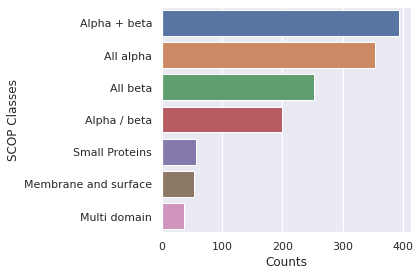

In [508]:
from matplotlib.pyplot import figure
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

#plt.tight_layout()
#plt.figure(figsize=(10,8))
sns.set_theme()
g = sns.countplot(y=jpred.SCOPClass, data=jpred, order=jpred.SCOPClass.value_counts().index)
g.set(xlabel='Counts', ylabel='SCOP Classes')
g.set_yticklabels(['Alpha + beta', 'All alpha', 'All beta', 'Alpha / beta', 'Small Proteins', 'Membrane and surface', 'Multi domain'])
fig = g.get_figure()
fig.savefig('../report/images/scop.png', dpi=300)

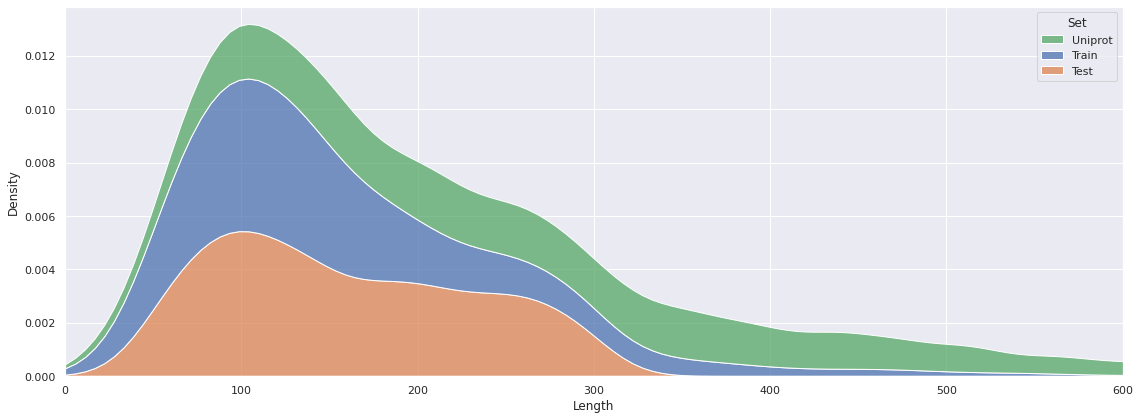

In [509]:

import os
uniprot = list()
train = list()
test= list()

full_test = pd.read_csv('../data/test/full_test.tsv', sep='\t', header=0)

with open('../data/uniprot_sprot.fasta') as f:
    count = 0
    for line in f:
        if not line.startswith('>'):
            count += len(line)
        else:
            if count < 1000:
                uniprot.append((count, 'Uniprot'))
                count = 0
            else:
                count = 0
    
    
    
for file in os.listdir('../data/training/dssp/'):
    with open('../data/training/dssp/' + file)as f:
        f.readline()
        count = len(f.readline())
        uniprot.append((count, 'Train'))
        
for struct in full_test.Structure:
    count = len(struct)
    uniprot.append((count, 'Test'))
 
df = pd.DataFrame(uniprot, columns=['Length', 'Set'])
sns.set_theme()

plt.figure(figsize=(16, 6))
g = sns.kdeplot(data=df,x='Length', hue='Set', common_norm=False, common_grid=True, multiple='stack', palette=["C2", "C0", "C1"])
g.set(xlim=(0,600))
fig = g.get_figure()
fig.savefig("../report/images/sequence_length.png", dpi=300)


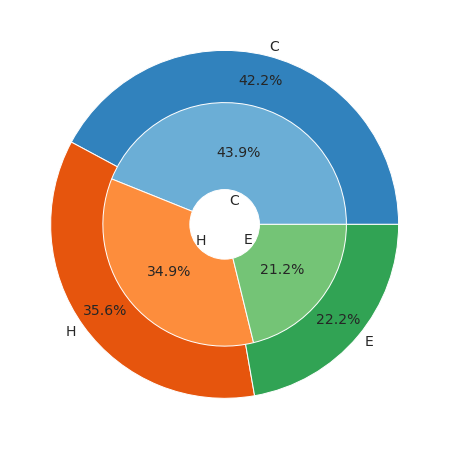

In [489]:
import numpy as np
from joblib import load
from matplotlib.pyplot import figure


the_blind = load('../data/test/the_blind.joblib')

train = {'C': 0,
            'H': 0,
            'E': 0}
test = {'C': 0,
            'H': 0,
            'E': 0}

for file in os.listdir('../data/training/dssp/'):
    with open('../data/training/dssp/' + file)as f:
        f.readline()
        for ss in f.readline().rstrip():
            if ss == '-':
                ss = 'C'
            train[ss] +=1
structure = the_blind.Class.value_counts()
structure.index = ['C', 'H', 'E']
test = {ss : structure[ss] for ss in structure.index}
fig, ax = plt.subplots()

#ax.axis('equal')
width = 0.3
cm = plt.get_cmap("tab20c")
cout = cm(np.arange(3)*4)

plt.pie([ss for ss in train.values()], 
        radius=1, 
        labels=list("CHE"),
        colors = cout,autopct="%1.1f%%", 
        labeldistance=1.05,
       pctdistance=0.85,textprops={'fontsize': 14})
cin = cm(np.array([1,5,9]))
plt.pie([ss for ss in test.values()], 
        radius=1-width, 
        labels=list('CHE'),    
        labeldistance=0.2, 
        colors=cin,
        autopct="%1.1f%%",textprops={'fontsize': 14})
fig.set_size_inches(8, 8)

my_circle = plt.Circle((0, 0), 0.2, color="white")
plt.gcf().gca().add_artist(my_circle)
plt.axis("off")
fig.savefig('../report/images/secondary.png', dpi=300)

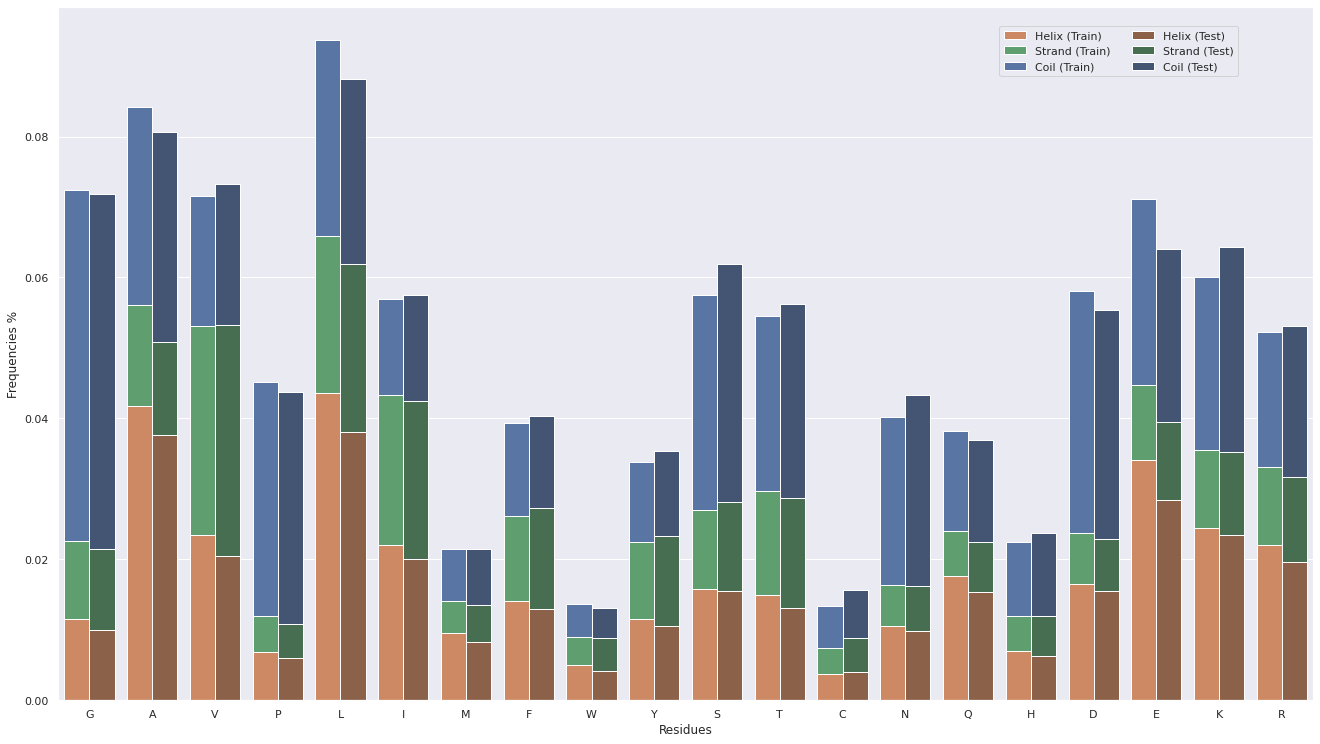

In [510]:
residues = list('GAVPLIMFWYSTCNQHDEKR')


train = {res: {ss: 0 for ss in ['H', 'E', 'C']} for res in residues}
test = {res: {ss: 0 for ss in ['H', 'E', 'C']} for res in residues}
tot=0
for file in os.listdir('../data/training/fasta/'):
    file = file[:-5]
    with open('../data/training/fasta/' + file + 'fasta') as fasta, open('../data/training/dssp/' + file + 'dssp') as dssp:
        fasta.readline()
        dssp.readline()
        for res, ss in zip(fasta.readline().rstrip(), dssp.readline().rstrip()):
            if res == 'X':
                continue
            if ss == '-':
                ss= 'C'
            tot += 1
            train[res][ss] +=1
            
train = {res:{ ss: train[res][ss] / tot for ss in ['H', 'C', 'E']} for res in train.keys()}

train = pd.DataFrame.from_dict(train).T.melt(var_name='Structure', value_name='Freq', ignore_index=False).reset_index()
train.rename({'index': 'Amino'}, axis=1, inplace=True)

tot=0
for _, sample in full_test.iterrows():
    structure = sample['Structure']
    sequence = sample['Sequence']
    for res, ss in zip(sequence, structure):
        test[res][ss]+= 1
        tot+=1
test = {res:{ ss: test[res][ss] / tot for ss in ['H', 'C', 'E']} for res in test.keys()}
test = pd.DataFrame.from_dict(test).T.melt(var_name='Structure', value_name='Freq', ignore_index=False).reset_index()
test.rename({'index': 'Amino'}, axis=1, inplace=True)

df = train.merge(test, on=['Amino', 'Structure'], suffixes=['train', 'test'])
df.rename({'Freqtrain': 'Train', 'Freqtest': 'Test'}, axis=1,inplace=True)

df =df.melt(id_vars=['Amino', 'Structure'], value_vars=['Train', 'Test'], var_name='Dataset', value_name='Freq')
df = df[df['Amino'] != 'X']
fig, ax = plt.subplots()


freqs_h = (
    df[df["Structure"] == "H"]
    .drop("Structure", axis=1)
    .set_index(["Amino", "Dataset"])
)
freqs_e = (
    df[df["Structure"] == "E"]
    .drop("Structure", axis=1)
    .set_index(["Amino", "Dataset"])
)
freqs_c = (
    df[df["Structure"] == "C"]
    .drop("Structure", axis=1)
    .set_index(["Amino", "Dataset"])
)
freqs_e_stacked = freqs_h + freqs_e
freqs_c_stacked = freqs_h + freqs_e + freqs_c
freqs_h = freqs_h.reset_index()
freqs_e_stacked = freqs_e_stacked.reset_index()
freqs_c_stacked = freqs_c_stacked.reset_index()
seaborn_blue, seaborn_orange, seaborn_green = sns.color_palette()[:3]
hue_order = ["Train", "Test"]
sns.barplot(
    data=freqs_c_stacked,
    hue="Dataset",
    x="Amino",
    y="Freq",
    order=residues,
    palette=sns.dark_palette(seaborn_blue, reverse=True)[::2],
    hue_order=hue_order
)
sns.barplot(
    data=freqs_e_stacked,
    hue="Dataset",
    x="Amino",
    y="Freq",
    order=residues,
    palette=sns.dark_palette(seaborn_green, reverse=True)[::2],
    hue_order=hue_order
)
sns.barplot(
    data=freqs_h,
    hue="Dataset",
    x="Amino",
    y="Freq",
    order=residues,
    palette=sns.dark_palette(seaborn_orange, reverse=True)[::2],
    hue_order=hue_order
)
handles = ax.get_legend_handles_labels()[0]
handle_names = [
    "Coil (Train)",
    "Coil (Test)",
    "Strand (Train)",
    "Strand (Test)",
    "Helix (Train)",
    "Helix (Test)",
]
handles = handles[::2][::-1] + handles[1::2][::-1]
handle_names = handle_names[::2][::-1] + handle_names[1::2][::-1]
ax.legend(handles, handle_names, loc=(0.75, 0.90), ncol=2)
ax.set_xlabel('Residues')
ax.set_ylabel('Frequencies %')
fig.set_size_inches(18.5, 10.5)
fig.savefig('../report/images/fraction_ss.png', dpi=300)